In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

In [2]:
lat, lon = 22.3363, 114.2634

params = [
    "ALLSKY_SFC_SW_DWN",   
    "CLRSKY_SFC_SW_DWN",   
    "T2M",                 
    "WS10M",
    "RH2M",
    "ALLSKY_KT",
    "SZA"
]
param_str = ",".join(params)

def fetch_range(start, end):
    url = (
        "https://power.larc.nasa.gov/api/temporal/hourly/point?"
        f"parameters={param_str}&community=RE"
        f"&longitude={lon}&latitude={lat}"
        f"&start={start}&end={end}&format=JSON"
    )
    r = requests.get(url)
    r.raise_for_status()
    d = r.json()
    df = pd.DataFrame(d["properties"]["parameter"])
    df.index = pd.to_datetime(df.index, format="%Y%m%d%H")
    df.sort_index(inplace=True)
    return df

df_weather = fetch_range("20220101", "20231231")
print(df_weather.head())


                     ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN    T2M  WS10M  \
2022-01-01 00:00:00                0.0                0.0  15.98   4.03   
2022-01-01 01:00:00                0.0                0.0  15.88   4.20   
2022-01-01 02:00:00                0.0                0.0  15.69   4.33   
2022-01-01 03:00:00                0.0                0.0  15.44   4.44   
2022-01-01 04:00:00                0.0                0.0  15.15   4.51   

                      RH2M  ALLSKY_KT   SZA  
2022-01-01 00:00:00  87.83     -999.0  90.0  
2022-01-01 01:00:00  87.66     -999.0  90.0  
2022-01-01 02:00:00  87.62     -999.0  90.0  
2022-01-01 03:00:00  87.35     -999.0  90.0  
2022-01-01 04:00:00  87.02     -999.0  90.0  


In [3]:
df_weather = fetch_range("20220101", "20231231")

# Replacing ALLSKY_KT = -999 with NaN (NASA missing / night flag)
df_weather["ALLSKY_KT"] = df_weather["ALLSKY_KT"].replace(-999.0, np.nan)
df_weather["is_night"] = (df_weather["SZA"] >= 89.9) | (df_weather["ALLSKY_SFC_SW_DWN"] <= 1.0)

print(df_weather.head(10))


                     ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN    T2M  WS10M  \
2022-01-01 00:00:00               0.00               0.00  15.98   4.03   
2022-01-01 01:00:00               0.00               0.00  15.88   4.20   
2022-01-01 02:00:00               0.00               0.00  15.69   4.33   
2022-01-01 03:00:00               0.00               0.00  15.44   4.44   
2022-01-01 04:00:00               0.00               0.00  15.15   4.51   
2022-01-01 05:00:00               0.00               0.00  14.88   4.58   
2022-01-01 06:00:00               0.00               0.00  14.56   4.46   
2022-01-01 07:00:00              35.20              37.75  14.74   4.78   
2022-01-01 08:00:00              95.20             208.45  15.73   5.04   
2022-01-01 09:00:00             190.62             397.05  17.35   4.82   

                      RH2M  ALLSKY_KT    SZA  is_night  
2022-01-01 00:00:00  87.83        NaN  90.00      True  
2022-01-01 01:00:00  87.66        NaN  90.00      True  
202

In [4]:
# Loading PV data (Tower A, Hong Kong University of Science and Technology)
tower_path = "Tower_A.csv" 

df_pv = pd.read_csv(tower_path)

# Parse time column
df_pv["Time"] = pd.to_datetime(df_pv["Time"])
df_pv = df_pv.set_index("Time").sort_index()

# Convert W → kW
df_pv["pv_power_kw"] = df_pv["power(W)"] / 1000.0

print(df_pv.head(20))
print(df_pv.index.min(), df_pv.index.max())


                     generation(kWh)  power(W)  pv_power_kw
Time                                                       
2022-03-25 01:00:00          0.00000      0.00      0.00000
2022-03-25 02:00:00          0.00000      0.00      0.00000
2022-03-25 03:00:00          0.00000      0.00      0.00000
2022-03-25 04:00:00          0.00000      0.00      0.00000
2022-03-25 05:00:00          0.00000      0.00      0.00000
2022-03-25 06:00:00          0.00000      0.00      0.00000
2022-03-25 07:00:00          0.00000      0.00      0.00000
2022-03-25 08:00:00          0.19225    192.25      0.19225
2022-03-25 09:00:00          0.65050    650.50      0.65050
2022-03-25 10:00:00          1.03900   1039.00      1.03900
2022-03-25 11:00:00          1.28950   1289.50      1.28950
2022-03-25 12:00:00          4.98550   4985.50      4.98550
2022-03-25 13:00:00          2.58200   2582.00      2.58200
2022-03-25 14:00:00          4.12350   4123.50      4.12350
2022-03-25 15:00:00          4.41025   4

In [5]:
# Merging weather and PV data
df = df_weather.join(df_pv[["pv_power_kw"]], how="inner")

print(df.head())
print(df.shape)
print("Merged period:", df.index.min(), "→", df.index.max())


                     ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN    T2M  WS10M  \
2022-03-25 01:00:00                0.0                0.0  20.74   6.13   
2022-03-25 02:00:00                0.0                0.0  21.04   6.06   
2022-03-25 03:00:00                0.0                0.0  21.42   6.03   
2022-03-25 04:00:00                0.0                0.0  21.79   5.85   
2022-03-25 05:00:00                0.0                0.0  22.12   6.11   

                      RH2M  ALLSKY_KT   SZA  is_night  pv_power_kw  
2022-03-25 01:00:00  96.40        NaN  90.0      True          0.0  
2022-03-25 02:00:00  96.73        NaN  90.0      True          0.0  
2022-03-25 03:00:00  97.13        NaN  90.0      True          0.0  
2022-03-25 04:00:00  97.67        NaN  90.0      True          0.0  
2022-03-25 05:00:00  97.71        NaN  90.0      True          0.0  
(15514, 9)
Merged period: 2022-03-25 01:00:00 → 2023-12-31 10:00:00


### Feature Engineering

In [6]:
def build_features(df_raw):
    df = df_raw.copy()

    # dropping rows with missing PV
    df = df.dropna(subset=["pv_power_kw"])

    # Time features
    df["hour"] = df.index.hour
    df["dayofyear"] = df.index.dayofyear
    df["month"] = df.index.month
    df["weekday"] = df.index.weekday
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)

    # Cyclical encodings
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["doy_sin"]  = np.sin(2 * np.pi * df["dayofyear"] / 365)
    df["doy_cos"]  = np.cos(2 * np.pi * df["dayofyear"] / 365)

    # Solar / cloudiness
    df["k_clearsky"] = df["ALLSKY_SFC_SW_DWN"] / df["CLRSKY_SFC_SW_DWN"].replace(0, np.nan)
    df["k_clearsky"] = df["k_clearsky"].clip(0, 2)

    # Solar geometry
    df["cos_zenith"] = np.cos(np.radians(df["SZA"]))

    # Cloudiness flag
    df["is_cloudy"] = (df["k_clearsky"] < 0.6).astype(int)

    # Weather
    df["temp_C"] = df["T2M"]
    df["temp_above_25"] = np.maximum(df["temp_C"] - 25, 0)
    df["wind_speed_10m"] = df["WS10M"]
    df["rel_humidity"] = df["RH2M"]

    # PV history (lags / rolling)
    df["pv_lag_1h"]  = df["pv_power_kw"].shift(1)
    df["pv_lag_24h"] = df["pv_power_kw"].shift(24)
    df["pv_roll_mean_3h"]  = df["pv_power_kw"].rolling(3).mean().shift(1)
    df["pv_roll_mean_24h"] = df["pv_power_kw"].rolling(24).mean().shift(1)

    # Target: PV 24h ahead
    df["target_pv_kw_tplus24"] = df["pv_power_kw"].shift(-24)

    # only daylight hours
    df = df[df["ALLSKY_SFC_SW_DWN"] > 10] 

    df = df.dropna(subset=[
        "target_pv_kw_tplus24",
        "pv_lag_1h", "pv_lag_24h",
        "pv_roll_mean_3h", "pv_roll_mean_24h",
        "k_clearsky", "cos_zenith", "temp_C"
    ])

    return df

df_features = build_features(df)

print(df_features.head())
print(df_features.shape)


                     ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN    T2M  WS10M  \
2022-03-26 07:00:00              87.88             187.23  24.35   3.83   
2022-03-26 08:00:00             180.55             416.92  25.16   4.43   
2022-03-26 09:00:00             282.85             627.30  25.94   5.07   
2022-03-26 10:00:00             389.00             791.70  26.50   5.43   
2022-03-26 11:00:00             549.62             894.30  26.90   5.79   

                      RH2M  ALLSKY_KT    SZA  is_night  pv_power_kw  hour  \
2022-03-26 07:00:00  95.86       0.25  74.89     False      0.00000     7   
2022-03-26 08:00:00  93.12       0.27  61.18     False      1.10350     8   
2022-03-26 09:00:00  88.79       0.31  47.82     False      3.37975     9   
2022-03-26 10:00:00  85.20       0.35  35.31     False      9.23350    10   
2022-03-26 11:00:00  83.06       0.44  25.05     False     10.11250    11   

                     ...  is_cloudy  temp_C  temp_above_25  wind_speed_10m  \
2022-03-

In [7]:
last_timestamp = df_features.index.max()
split_date = last_timestamp - pd.Timedelta(days=90)

train = df_features[df_features.index < split_date]
test  = df_features[df_features.index >= split_date]

print("Train:", train.index.min(), "→", train.index.max(), "n =", len(train))
print("Test :", test.index.min(),  "→", test.index.max(),  "n =", len(test))

Train: 2022-03-26 07:00:00 → 2023-10-01 09:00:00 n = 6454
Test : 2023-10-01 10:00:00 → 2023-12-30 10:00:00 n = 975


In [8]:
feature_cols = [
    # irradiance / solar
    "ALLSKY_SFC_SW_DWN", "CLRSKY_SFC_SW_DWN",
    "k_clearsky", "ALLSKY_KT", "cos_zenith",
    # weather
    "temp_C", "temp_above_25",
    "wind_speed_10m", "rel_humidity",
    # time
    "hour_sin", "hour_cos", "doy_sin", "doy_cos",
    # PV history
    "pv_lag_1h", "pv_lag_24h", "pv_roll_mean_3h", "pv_roll_mean_24h",
]

X_train = train[feature_cols]
y_train = train["target_pv_kw_tplus24"]

X_test = test[feature_cols]
y_test = test["target_pv_kw_tplus24"]

In [9]:
# Baseline model
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape_val = mape(y_true, y_pred)
    print(f"{name:25s} | MAE: {mae:.3f} kW | RMSE: {rmse:.3f} kW | MAPE: {mape_val:.1f}%")

# Persistence baseline
y_pred_persistence = test["pv_lag_24h"].values

evaluate(y_test, y_pred_persistence, "Persistence (day-ahead)")

Persistence (day-ahead)   | MAE: 4.569 kW | RMSE: 7.037 kW | MAPE: 122.1%


In [10]:
# Machine Learning model: Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
)

gbr.fit(X_train, y_train)

y_pred_ml = gbr.predict(X_test)

evaluate(y_test, y_pred_ml, "GradientBoosting (day-ahead)")

GradientBoosting (day-ahead) | MAE: 3.664 kW | RMSE: 4.973 kW | MAPE: 142.2%


In [11]:
# feature importance
fi = pd.Series(gbr.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(fi)

pv_lag_1h            0.422213
ALLSKY_SFC_SW_DWN    0.159801
pv_lag_24h           0.096653
pv_roll_mean_3h      0.050409
ALLSKY_KT            0.046609
CLRSKY_SFC_SW_DWN    0.045254
doy_sin              0.043311
rel_humidity         0.029478
doy_cos              0.022328
wind_speed_10m       0.019305
temp_C               0.017304
cos_zenith           0.011710
temp_above_25        0.010514
pv_roll_mean_24h     0.010509
k_clearsky           0.008101
hour_sin             0.004822
hour_cos             0.001677
dtype: float64


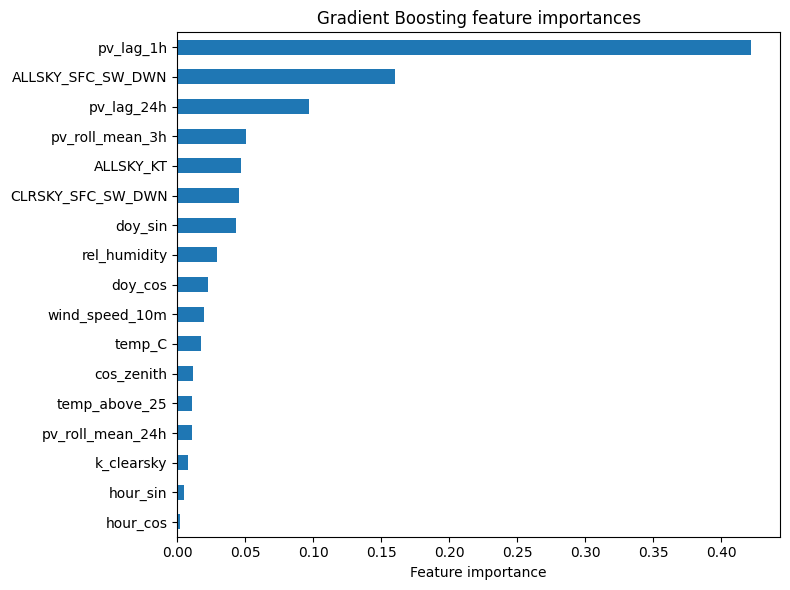

In [17]:
fi = pd.Series(gbr.feature_importances_, index=feature_cols).sort_values()

plt.figure(figsize=(8, 6))
fi.plot(kind="barh")
plt.xlabel("Feature importance")
plt.title("Gradient Boosting feature importances")
plt.tight_layout()
plt.show()


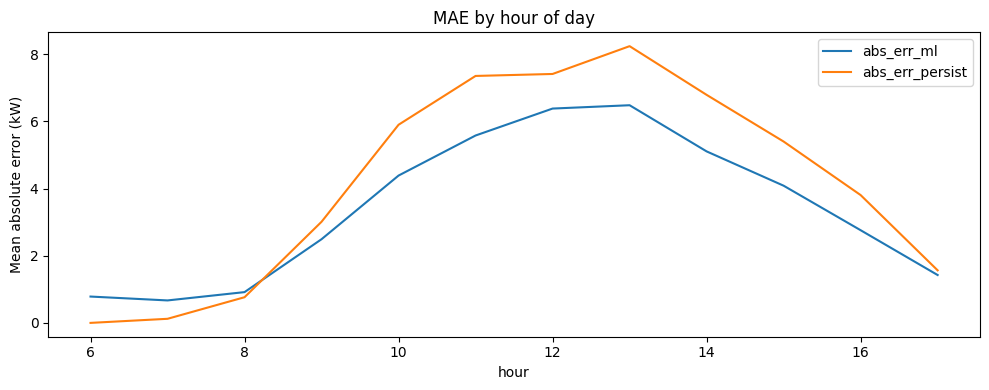

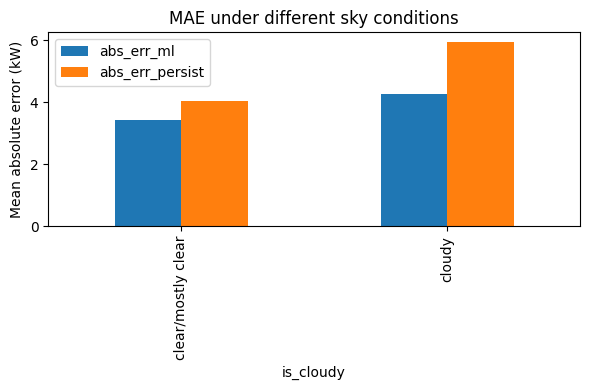

In [12]:
results = test.copy()
results["y_true"] = y_test
results["y_pred_ml"] = y_pred_ml
results["y_pred_persist"] = y_pred_persistence

results["abs_err_ml"] = np.abs(results["y_true"] - results["y_pred_ml"])
results["abs_err_persist"] = np.abs(results["y_true"] - results["y_pred_persist"])

# Error by hour of day
hourly_err = results.groupby("hour")[["abs_err_ml", "abs_err_persist"]].mean()

plt.figure(figsize=(10, 4))
hourly_err.plot(ax=plt.gca())
plt.ylabel("Mean absolute error (kW)")
plt.title("MAE by hour of day")
plt.tight_layout()
plt.show()

# Error under clear vs cloudy
cloudy_err = results.groupby("is_cloudy")[["abs_err_ml", "abs_err_persist"]].mean()
cloudy_err.index = cloudy_err.index.map({0: "clear/mostly clear", 1: "cloudy"})

plt.figure(figsize=(6, 4))
cloudy_err.plot(kind="bar", ax=plt.gca())
plt.ylabel("Mean absolute error (kW)")
plt.title("MAE under different sky conditions")
plt.tight_layout()
plt.show()

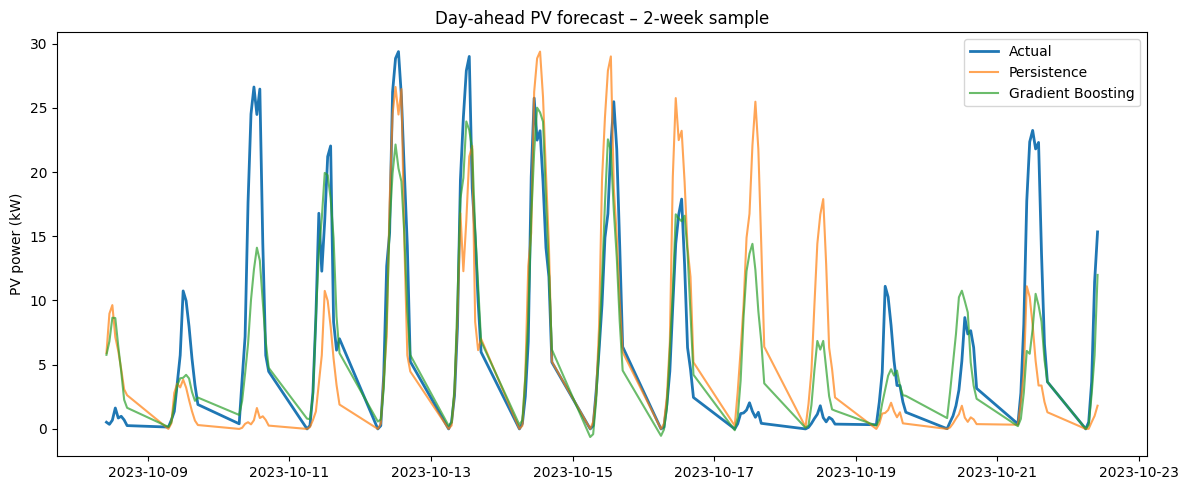

In [13]:
start = results.index.min() + pd.Timedelta(days=7)
end   = start + pd.Timedelta(days=14)

ts_slice = results.loc[start:end]

plt.figure(figsize=(12, 5))
plt.plot(ts_slice.index, ts_slice["y_true"], label="Actual", linewidth=2)
plt.plot(ts_slice.index, ts_slice["y_pred_persist"], label="Persistence", alpha=0.7)
plt.plot(ts_slice.index, ts_slice["y_pred_ml"], label="Gradient Boosting", alpha=0.7)
plt.ylabel("PV power (kW)")
plt.title("Day-ahead PV forecast – 2-week sample")
plt.legend()
plt.tight_layout()
plt.show()

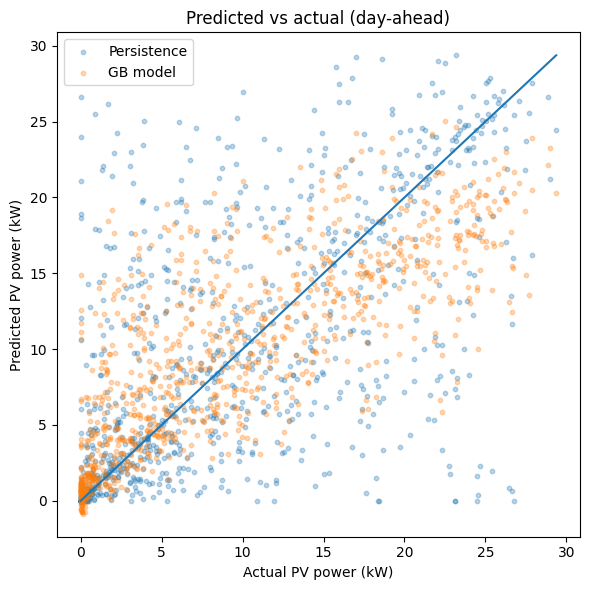

In [14]:
plt.figure(figsize=(6, 6))

plt.scatter(results["y_true"], results["y_pred_persist"], s=10, alpha=0.3, label="Persistence")
plt.scatter(results["y_true"], results["y_pred_ml"], s=10, alpha=0.3, label="GB model")

max_val = max(results["y_true"].max(), results["y_pred_ml"].max(), results["y_pred_persist"].max())
plt.plot([0, max_val], [0, max_val])  # 1:1 line

plt.xlabel("Actual PV power (kW)")
plt.ylabel("Predicted PV power (kW)")
plt.title("Predicted vs actual (day-ahead)")
plt.legend()
plt.tight_layout()
plt.show()


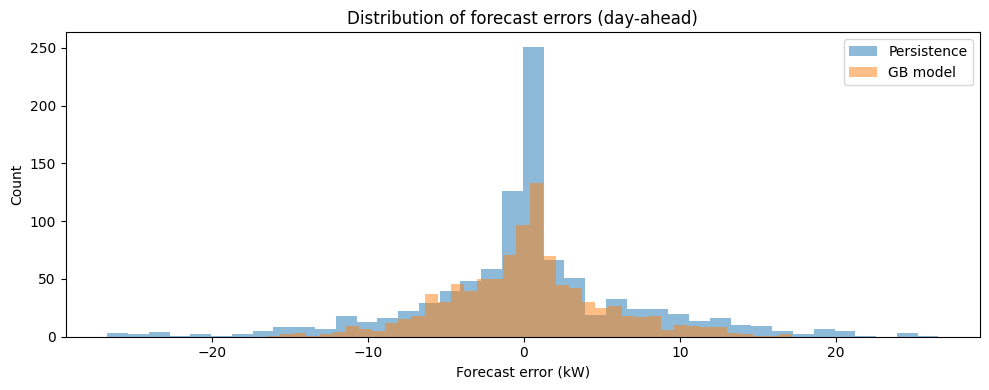

In [15]:
results["err_persist"] = results["y_pred_persist"] - results["y_true"]
results["err_ml"] = results["y_pred_ml"] - results["y_true"]

plt.figure(figsize=(10, 4))

plt.hist(results["err_persist"], bins=40, alpha=0.5, label="Persistence")
plt.hist(results["err_ml"], bins=40, alpha=0.5, label="GB model")

plt.xlabel("Forecast error (kW)")
plt.ylabel("Count")
plt.title("Distribution of forecast errors (day-ahead)")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_19335/1048118437.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = results.groupby("power_bin")[["abs_err_ml", "abs_err_persist"]].mean()


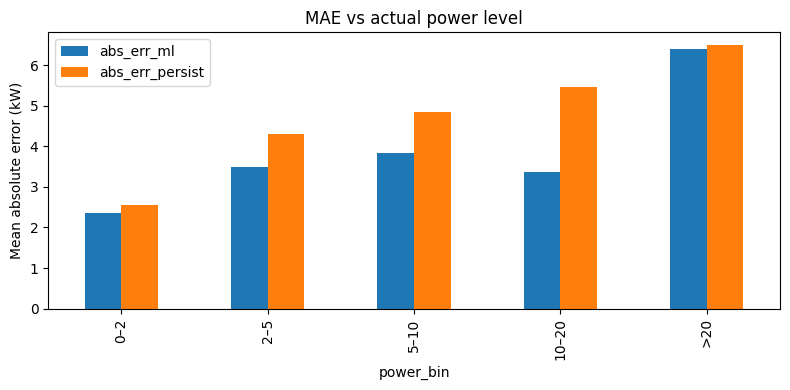

In [16]:
bins = [0, 2, 5, 10, 20, 40]  
labels = ["0–2", "2–5", "5–10", "10–20", ">20"]

results["power_bin"] = pd.cut(results["y_true"], bins=bins, labels=labels, include_lowest=True)

grouped = results.groupby("power_bin")[["abs_err_ml", "abs_err_persist"]].mean()

plt.figure(figsize=(8, 4))
grouped.plot(kind="bar", ax=plt.gca())
plt.ylabel("Mean absolute error (kW)")
plt.title("MAE vs actual power level")
plt.tight_layout()
plt.show()


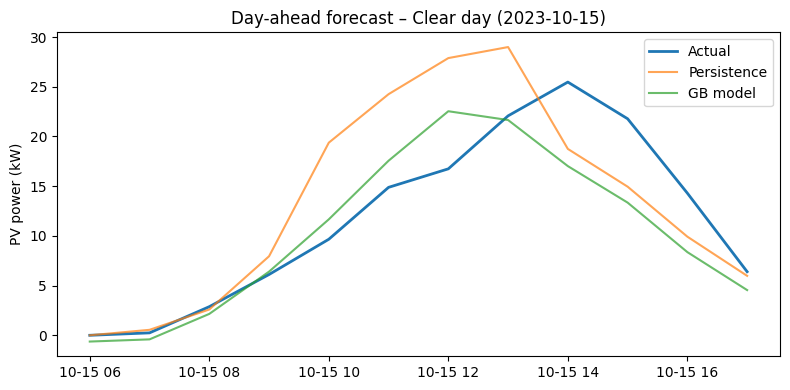

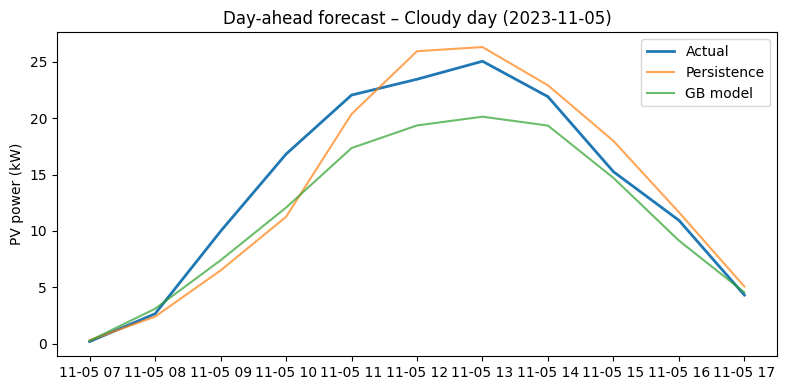

In [18]:
day_clear = "2023-10-15"
day_cloudy = "2023-11-05"

for day, label in [(day_clear, "Clear day"), (day_cloudy, "Cloudy day")]:
    day_slice = results.loc[day]
    plt.figure(figsize=(8, 4))
    plt.plot(day_slice.index, day_slice["y_true"], label="Actual", linewidth=2)
    plt.plot(day_slice.index, day_slice["y_pred_persist"], label="Persistence", alpha=0.7)
    plt.plot(day_slice.index, day_slice["y_pred_ml"], label="GB model", alpha=0.7)
    plt.ylabel("PV power (kW)")
    plt.title(f"Day-ahead forecast – {label} ({day})")
    plt.legend()
    plt.tight_layout()
    plt.show()
